<a href="https://colab.research.google.com/github/ozturkc/FuzzyGA-PortfolioOpt/blob/main/Fuzzy_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Change working directory to a desired folder in your Drive
#    (Ensure that this folder path actually exists or create it beforehand)
os.chdir('/content/drive/MyDrive/Fuzzy-GA')

# 3. Verify current directory
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Fuzzy-GA


In [2]:
# GPU kullanımı için ayar: GPU varsa kullan, yoksa CPU kullan
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Kullanılan cihaz:", device)

Kullanılan cihaz: cpu


# Çalışmanın Genel Amacı

Bu çalışma, Dow Jones Industrial Average (DJIA) endeksindeki 30 hisse senedinden oluşan bir portföyün optimizasyonunu hedefler. Optimizasyon, genetik algoritma ve fuzzy logic (bulanık mantık) kombinasyonuyla gerçekleştirilir. Ayrıca, klasik portföy optimizasyon yöntemleri (Markowitz, Equal Weight, Min Variance) ile karşılaştırma yapılır.

Yapı

1. Veri indirme ve hazırlama
2. Fuzzy üyelik fonksiyonlarının dinamik olarak tanımlanması
3. Fuzzy inference sisteminin kurulması
4. Genetik algoritma ile optimizasyon
5. Benchmark portföylerin oluşturulması
6. Performans metriklerinin hesaplanması ve karşılaştırılması
7. Görselleştirmeler





# 1. Veri İndirme ve Hazırlama

Bu bölümde, DJIA hisse senetlerinin kapanış fiyatları indirilir, eksik veriler temizlenir ve günlük getiriler hesaplanır. Yıllık getiri ve kovaryans matrisi de türetilir.

### Günlük Getiri
$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

### Yıllık Getiri
$$
E[R] = \text{ortalama}(R_t) \times 252
$$
*(252 iş günü varsayımı)*

### Kovaryans Matrisi
$$
\text{Cov}(R_i, R_j) = \frac{1}{n-1} \sum (R_i - \bar{R_i})(R_j - \bar{R_j}) \times 252
$$


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime

# DJIA bileşenleri
djia_tickers = [
    "AAPL", "AMGN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS", "DOW",
    "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM",
    "MRK", "MSFT", "NKE", "PG", "TRV", "UNH", "V", "VZ", "WBA", "WMT"
]

# Güncel tarih ile veri indirme
# end_date = datetime.datetime.now().strftime('%Y-%m-%d')
data = yf.download(djia_tickers, start='2020-01-01', end='2025-03-10')['Close']
data = data.fillna(method='ffill').dropna()

# Getiri ve kovaryans hesaplamaları
returns = data.pct_change().dropna()
n_assets = len(returns.columns)
expected_returns = returns.mean().values * 252  # Yıllık getiri
cov_matrix = returns.cov().values * 252        # Yıllık kovaryans

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  30 of 30 completed
<ipython-input-3-990fec323141>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').dropna()


# 2. Dinamik Üyelik Fonksiyonları

Risk ve Sharpe oranı için bulanık üyelik fonksiyonları, piyasa verilerine (volatilite ve Sharpe oranları) dayalı olarak dinamik bir şekilde tanımlanır.

### Risk Eşikleri
- Varlık volatilitelerinin minimum, medyan ve maksimum değerlerine göre belirlenir.

### Sharpe Eşikleri
- Varlıkların Sharpe oranlarının minimum, medyan ve maksimum değerlerine göre ayarlanır.


In [4]:
# Varlık volatiliteleri ve Sharpe oranları
asset_volatilities = np.sqrt(np.diag(cov_matrix))
asset_sharpes = expected_returns / asset_volatilities

# Risk eşikleri: min, median, max volatilite
risk_min = np.min(asset_volatilities)
risk_max = np.max(asset_volatilities)
risk_med = np.median(asset_volatilities)

# Sharpe eşikleri: min, median, max Sharpe
sharpe_min = np.min(asset_sharpes)
sharpe_max = np.max(asset_sharpes)
sharpe_med = np.median(asset_sharpes)

# Risk üyelik fonksiyonları
def risk_low(r):
    if r <= risk_min: return 1.0
    elif r >= risk_med: return 0.0
    else: return (risk_med - r) / (risk_med - risk_min)

def risk_medium(r):
    if r <= risk_min or r >= risk_max: return 0.0
    elif risk_min < r <= risk_med: return (r - risk_min) / (risk_med - risk_min)
    elif risk_med < r < risk_max: return (risk_max - r) / (risk_max - risk_med)
    else: return 0.0

def risk_high(r):
    if r <= risk_med: return 0.0
    elif r >= risk_max: return 1.0
    else: return (r - risk_med) / (risk_max - risk_med)

# Sharpe üyelik fonksiyonları
def sharpe_low(s):
    if s <= sharpe_min: return 1.0
    elif s >= sharpe_med: return 0.0
    else: return (sharpe_med - s) / (sharpe_med - sharpe_min)

def sharpe_medium(s):
    if s <= sharpe_min or s >= sharpe_max: return 0.0
    elif sharpe_min < s <= sharpe_med: return (s - sharpe_min) / (sharpe_med - sharpe_min)
    elif sharpe_med < s < sharpe_max: return (sharpe_max - s) / (sharpe_max - sharpe_med)
    else: return 0.0

def sharpe_high(s):
    if s <= sharpe_med: return 0.0
    elif s >= sharpe_max: return 1.0
    else: return (s - sharpe_med) / (sharpe_max - sharpe_med)

# 3. Fuzzy Inference Sistemi

Risk ve Sharpe oranına dayalı olarak portföyün fitness değerini hesaplamak için bulanık çıkarım sistemi kurulur.

### Kural Aktivasyonu
$$
\mu_{\text{kural}} = \min(\mu_{\text{risk}}, \mu_{\text{sharpe}})
$$

### Defuzzification
$$
\text{Fitness} = \frac{\sum (\mu_i \cdot v_i)}{\sum \mu_i}
$$


In [5]:
def fuzzy_inference(risk_val, sharpe_val):
    # Üyelik dereceleri
    r_low, r_med, r_high = risk_low(risk_val), risk_medium(risk_val), risk_high(risk_val)
    s_low, s_med, s_high = sharpe_low(sharpe_val), sharpe_medium(sharpe_val), sharpe_high(sharpe_val)

    # Kurallar (fitness: Low=0.3, Medium=0.6, High=0.9)
    rules = [
        (min(r_low, s_high), 0.9), (min(r_low, s_med), 0.9), (min(r_low, s_low), 0.6),
        (min(r_med, s_high), 0.9), (min(r_med, s_med), 0.6), (min(r_med, s_low), 0.3),
        (min(r_high, s_high), 0.6), (min(r_high, s_med), 0.3), (min(r_high, s_low), 0.3)
    ]

    # Defuzzification
    numerator = sum(activation * value for activation, value in rules)
    denominator = sum(activation for activation, _ in rules)
    return numerator / denominator if denominator != 0 else 0

# 4. Genetik Algoritma ile Optimizasyon

Portföy ağırlıkları genetik algoritma ile optimize edilir; fitness fonksiyonu fuzzy inference sistemini kullanır.

### Portföy Getirisi
$$
R_p = w^T \cdot E[R]
$$

### Portföy Riski
$$
\sigma_p = w^T \cdot \Sigma \cdot w
$$

### Sharpe Oranı
$$
S = \frac{R_p - R_f}{\sigma_p}
$$


In [6]:
def calculate_fitness(individual, risk_free):
    ret = np.dot(individual, expected_returns)
    risk_val = np.sqrt(np.dot(individual.T, np.dot(cov_matrix, individual)))
    sharpe = (ret - risk_free) / risk_val if risk_val != 0 else 0
    return fuzzy_inference(risk_val, sharpe)

def init_population(pop_size, n_assets):
    pop = np.random.rand(pop_size, n_assets)
    return pop / pop.sum(axis=1, keepdims=True)

def optimize_portfolio_ga(generations=100, pop_size=1000, mutation_rate=0.1, risk_free=0.02):
    population = init_population(pop_size, n_assets)
    for _ in range(generations):
        fitnesses = np.array([calculate_fitness(ind, risk_free) for ind in population])
        best_idx = np.argmax(fitnesses)
        n_select = max(2, int(0.2 * pop_size))
        selected = population[np.argsort(fitnesses)[-n_select:]]

        new_population = []
        while len(new_population) < pop_size:
            parent1, parent2 = selected[np.random.choice(len(selected), 2, replace=False)]
            alpha = np.random.uniform(0.5, 1.5, n_assets)
            child = alpha * parent1 + (1 - alpha) * parent2
            child = np.abs(child) / child.sum()
            if np.random.rand() < mutation_rate:  # Mutasyon
                child += np.random.normal(0, 0.05, n_assets)
                child = np.abs(child) / child.sum()
            new_population.append(child)

        new_population[0] = population[best_idx]  # Elitizm
        population = np.array(new_population)

    fitnesses = np.array([calculate_fitness(ind, risk_free) for ind in population])
    return population[np.argmax(fitnesses)]

# 5. Benchmark Portföyler

Klasik yöntemlerle portföyler oluşturulur.

### Equal Weight
$$
w_i = \frac{1}{n}
$$

### Min Variance
$$
\min_{w} \quad w^T \cdot \Sigma \cdot w
$$

Kısıtlar:
$$
\sum_{i} w_i = 1, \quad 0 \leq w_i \leq 1
$$

### Markowitz
$$
\min_{w} \quad w^T \cdot \Sigma \cdot w
$$

Kısıtlar:
$$
w^T \cdot E[R] = R_{\text{target}}, \quad \sum_{i} w_i = 1
$$


In [7]:
def equal_weight():
    return np.ones(n_assets) / n_assets

def min_variance():
    def objective(w): return np.dot(w.T, np.dot(cov_matrix, w))
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(n_assets)]
    result = minimize(objective, equal_weight(), method='SLSQP', constraints=constraints, bounds=bounds)
    return result.x

def markowitz(target_return):
    def objective(w): return np.dot(w.T, np.dot(cov_matrix, w))
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, expected_returns) - target_return}
    ]
    bounds = [(0, 1) for _ in range(n_assets)]
    result = minimize(objective, equal_weight(), method='SLSQP', constraints=constraints, bounds=bounds)
    return result.x

# 6. Performans Metrikleri

Grafiklere geçmeden önce, her bir performans metriğinin neyi temsil ettiğini, nasıl hesaplandığını ve istenen değerlerini anlamak önemlidir. Bu metrikler portföy optimizasyonunda kullanılır ve yatırımın getiri, risk ve genel performansını değerlendirir.

## 1. Return (Getiri)

**Anlamı:**  
Portföyün beklenen yıllık getirisidir. Yatırımın ne kadar kazanç sağladığını gösterir.

**Matematiksel İfade:**
$$
R_p = w^T \cdot E[R]
$$
- **\(w\):** Portföydeki varlıkların ağırlıkları  
- **\(E[R]\):** Varlıkların beklenen getirileri

**İstenen Değer:**  
Yüksek olması istenir, çünkü daha fazla kazanç anlamına gelir.

## 2. Risk (Risk)

**Anlamı:**  
Portföyün volatilitesi veya standart sapmasıdır. Yatırımın ne kadar dalgalandığını (belirsizlik taşıdığını) belirtir.

**Matematiksel İfade:**
$$
\sigma_p = w^T \cdot \Sigma \cdot w
$$
- **\(\Sigma\):** Varlıkların kovaryans matrisi

**İstenen Değer:**  
Düşük olması istenir, çünkü daha az dalgalanma daha az risk demektir.

## 3. Sharpe (Sharpe Oranı)

**Anlamı:**  
Portföyün riski dikkate alınarak elde edilen getirisini ölçer. Bir birim risk için ne kadar getiri sağlandığını gösterir.

**Matematiksel İfade:**
$$
S = \frac{R_p - R_f}{\sigma_p}
$$
- **\(R_f\):** Risksiz getiri oranı (örneğin, devlet tahvil getirisi)

**İstenen Değer:**  
Yüksek olması istenir, çünkü daha iyi bir risk-kazanç dengesi anlamına gelir.

## 4. Max Drawdown (Maksimum Düşüş)

**Anlamı:**  
Portföyün en yüksek değerinden en düşük değerine kadar yaşadığı maksimum kayıp yüzdesidir. En kötü senaryoyu gösterir.

**Matematiksel İfade:**
$$
\text{MDD} = \max(\text{Peak} - \text{Cumulative Peak})
$$

**İstenen Değer:**  
Düşük olması istenir, çünkü daha az kayıp riski anlamına gelir.

## 5. Diversification (Çeşitlendirme)

**Anlamı:**  
Portföyün riskinin, varlıkların bireysel risklerine oranını ölçer. Çeşitlendirme derecesini gösterir.

**Matematiksel İfade:**
$$
D = \frac{\sum_i w_i \cdot \sigma_i}{\sigma_p}
$$
- **\(\sigma_i\):** Varlıkların bireysel volatiliteleri

**İstenen Değer:**  
Yüksek olması istenir, çünkü daha iyi risk dağılımı sağlar.

## 6. Fuzzy Score (Bulanık Skor)

**Anlamı:**  
Portföyün risk ve Sharpe oranına dayalı olarak bulanık mantık kullanılarak hesaplanan genel performans skorudur.

**Matematiksel İfade:**  
Bulanık mantık sistemi (fuzzy inference) ile hesaplanır.

**İstenen Değer:**  
Yüksek olması istenir, çünkü daha iyi genel performans anlamına gelir.



In [8]:
def calculate_metrics(weights, risk_free=0.02):
    ret = np.dot(weights, expected_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - risk_free) / risk if risk != 0 else 0
    cumulative_returns = np.cumprod(1 + returns @ weights)
    max_drawdown = np.max((np.maximum.accumulate(cumulative_returns) - cumulative_returns) / np.maximum.accumulate(cumulative_returns))
    diversification = np.sum([w * np.sqrt(cov_matrix[i, i]) for i, w in enumerate(weights)]) / risk if risk != 0 else 0
    return {
        'Return': ret,
        'Risk': risk,
        'Sharpe': sharpe,
        'Max Drawdown': max_drawdown,
        'Diversification': diversification,
        'Fuzzy Score': fuzzy_inference(risk, sharpe)
    }

# 7. Portföy Optimizasyonu ve Karşılaştırma

Portföyler optimize edilir ve sonuçlar karşılaştırılır. Risk-free oranı kullanıcı tarafından ayarlanabilir.

In [9]:
# Kullanıcı parametreleri
risk_free_rate = 0.02  # Örnek: ABD 10 yıllık hazine bonosu getirisi
generations = 100
pop_size = 1000
mutation_rate = 0.1

# Portföy optimizasyonu
ga_weights = optimize_portfolio_ga(generations=generations, pop_size=pop_size, mutation_rate=mutation_rate, risk_free=risk_free_rate)
target_return = expected_returns.mean()
markowitz_weights = markowitz(target_return)

portfolios = {
    'Fuzzy-GA': ga_weights,
    'Markowitz': markowitz_weights,
    'Equal Weight': equal_weight(),
    'Min Variance': min_variance()
}

results = {name: calculate_metrics(weights, risk_free=risk_free_rate) for name, weights in portfolios.items()}
df_results = pd.DataFrame(results).T
print("Performans Karşılaştırması:")
print(df_results.sort_values('Sharpe', ascending=False))

Performans Karşılaştırması:
                Return      Risk    Sharpe  Max Drawdown  Diversification  \
Markowitz     0.119396  0.154711  0.642463      0.202519         1.478977   
Min Variance  0.104690  0.154075  0.549666      0.202574         1.471222   
Fuzzy-GA      0.117183  0.195115  0.498081      0.313736         1.505871   
Equal Weight  0.119396  0.202205  0.491562      0.334619         1.516263   

              Fuzzy Score  
Markowitz        0.900000  
Min Variance     0.900000  
Fuzzy-GA         0.900000  
Equal Weight     0.884056  


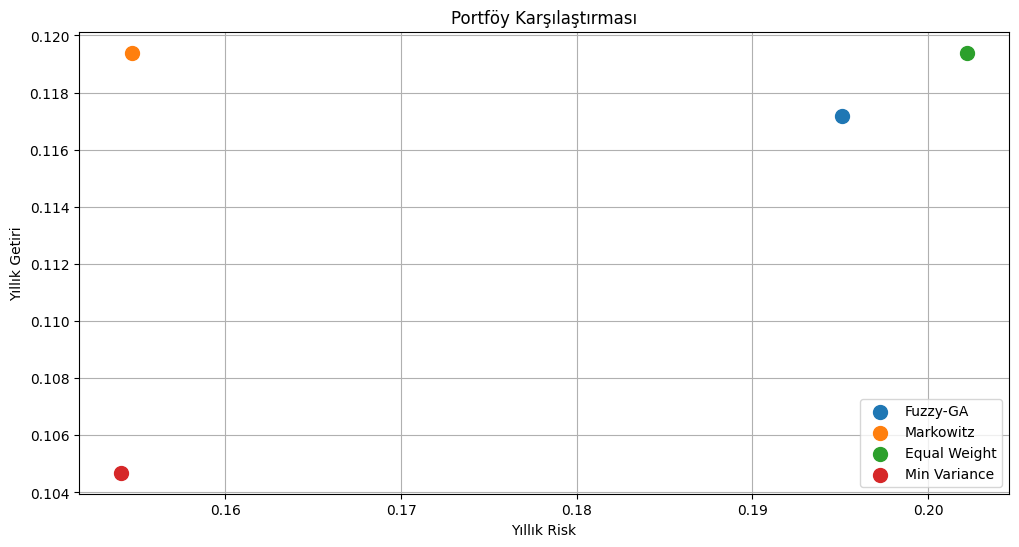

In [10]:
plt.figure(figsize=(12, 6))
for name, vals in df_results.iterrows():
    plt.scatter(vals['Risk'], vals['Return'], label=name, s=100)
plt.xlabel('Yıllık Risk')
plt.ylabel('Yıllık Getiri')
plt.title('Portföy Karşılaştırması')
plt.legend()
plt.grid(True)
plt.show()

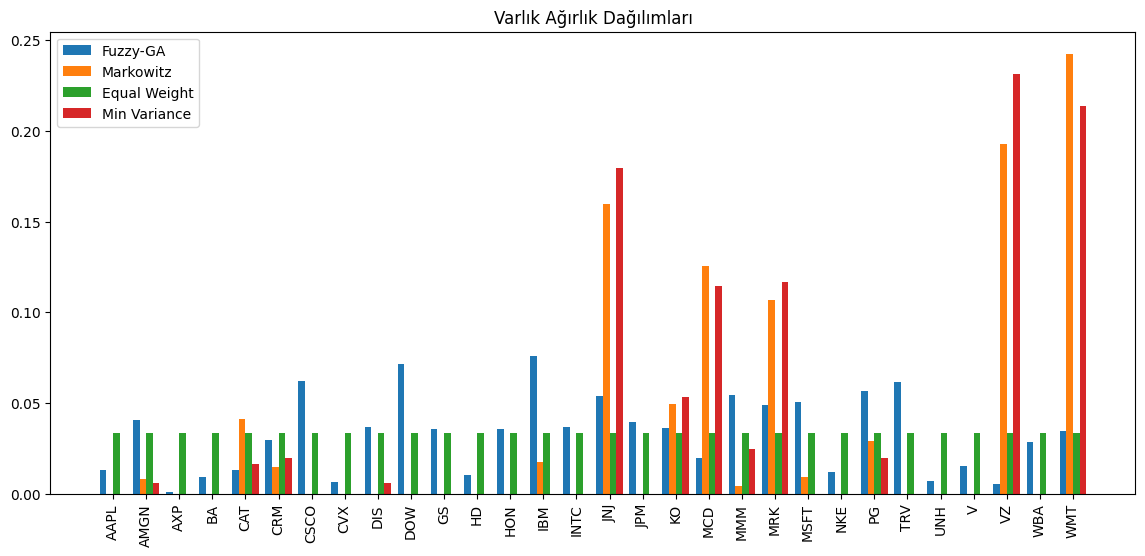

In [11]:
plt.figure(figsize=(14, 6))
x = np.arange(n_assets)
bar_width = 0.2
plt.bar(x - 1.5*bar_width, ga_weights, width=bar_width, label='Fuzzy-GA')
plt.bar(x - 0.5*bar_width, markowitz_weights, width=bar_width, label='Markowitz')
plt.bar(x + 0.5*bar_width, equal_weight(), width=bar_width, label='Equal Weight')
plt.bar(x + 1.5*bar_width, min_variance(), width=bar_width, label='Min Variance')
plt.xticks(x, returns.columns, rotation=90)
plt.title('Varlık Ağırlık Dağılımları')
plt.legend()
plt.show()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Portföy isimlerine göre renkler
colors = {
    'Fuzzy-GA': '#2ecc71',       # Yeşil
    'Markowitz': '#3498db',      # Mavi
    'Equal Weight': '#f1c40f',   # Sarı
    'Min Variance': '#e74c3c'    # Kırmızı
}

# Grafiklerin oluşturulması
metrics = ['Return', 'Risk', 'Sharpe', 'Max Drawdown', 'Diversification', 'Fuzzy Score']
fig, axs = plt.subplots(2, 3, figsize=(20, 12), dpi=500)
axs = axs.flatten()

# Seaborn ile modern stil
sns.set_style("whitegrid")

for i, metric in enumerate(metrics):
    # Bar grafiği, her portföy için özel renklerle
    sns.barplot(x=df_results.index, y=df_results[metric], ax=axs[i],
                palette=[colors[port] for port in df_results.index])

    # Başlık ve etiketler
    axs[i].set_title(f'{metric} Karşılaştırması', fontsize=14, fontweight='bold', pad=10)
    axs[i].set_ylabel(metric, fontsize=12)
    axs[i].set_xlabel('Portföy Yöntemleri', fontsize=12)

    # Grid çizgileri
    axs[i].grid(True, linestyle='--', alpha=0.5)

    # Her barın üzerine değer ekleme
    for p in axs[i].patches:
        axs[i].annotate(f'{p.get_height():.2f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black',
                        xytext=(0, 5), textcoords='offset points')

# Genel düzenlemeler
plt.suptitle('Portföy Performans Metrikleri Karşılaştırması', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('portfolio_metrics.png', dpi=500, bbox_inches='tight')
plt.show()

<ipython-input-21-cf8fea752a82>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_results.index, y=df_results[metric], ax=axs[i],
<ipython-input-21-cf8fea752a82>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_results.index, y=df_results[metric], ax=axs[i],
<ipython-input-21-cf8fea752a82>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_results.index, y=df_results[metric], ax=axs[i],
<ipython-input-21-cf8fea752a82>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. A